### Tahap 1: Pemuatan Data dan Inisialisasi

In [19]:
# Tahap 1: Pemuatan Data dan Inisialisasi
# ==========================================

import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
# --- PERBAIKAN ---
# Menambahkan 'mean_squared_error' yang hilang ke dalam daftar impor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Menambahkan library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Mengatur path untuk memuat data spasial yang baru
# dan menyimpan hasil prediksi dengan nama baru.
PATH_SPLIT_DATA = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\split_data'
PATH_PREDICTIONS = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'
os.makedirs(PATH_PREDICTIONS, exist_ok=True)

# Muat dataset dengan fitur spasial
train_df = pd.read_parquet(os.path.join(PATH_SPLIT_DATA, 'train_set_spatial.parquet'))
test_df = pd.read_parquet(os.path.join(PATH_SPLIT_DATA, 'test_set_spatial.parquet'))

# Hapus baris dengan nilai NaN yang muncul dari fitur lag & spasial
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# --- Definisikan Fitur dan Target ---
TARGET = 'konsumsi_energi'

# Menambahkan fitur-fitur spasial ke dalam daftar fitur yang akan digunakan.
# Kolom 'koordinat' yang bertipe object juga dihapus.
FEATURES = [col for col in train_df.columns if col not in ['timestamp', 'meter_id', 'koordinat', TARGET]]

print("Data Latih dan Uji (spasial) berhasil dimuat.")
print(f"Jumlah Fitur yang akan digunakan: {len(FEATURES)}")
print("Contoh fitur:", FEATURES[:7]) # Tampilkan beberapa contoh fitur

Data Latih dan Uji (spasial) berhasil dimuat.
Jumlah Fitur yang akan digunakan: 19
Contoh fitur: ['is_kelas', 'is_kantor', 'is_penelitian', 'avg_temp_previous_hour', 'jam', 'hari_minggu', 'hari_bulan']


### Tahap 2: Pra-pemrosesan Data

In [7]:
# Tahap 2: Pra-pemrosesan Data
# ==========================================
# Logika di tahap ini sebagian besar tetap sama, karena sudah dirancang
# untuk menangani jumlah fitur yang dinamis.

# --- Konfigurasi LSTM ---
N_PAST = 24     # Menggunakan data 24 jam terakhir
N_FUTURE = 1    # Untuk memprediksi 1 jam ke depan

X_train, y_train = [], []
X_test, y_test = [], []
scalers = {}    # Dictionary untuk menyimpan scaler untuk setiap gedung

# --- Proses Data Latih ---
print("\nMemproses Data Latih untuk sekuens LSTM...")
for meter_id, group in train_df.groupby('meter_id'):
    scaler = MinMaxScaler()
    group_scaled = scaler.fit_transform(group[FEATURES + [TARGET]])
    scalers[meter_id] = scaler
    
    for i in range(N_PAST, len(group_scaled) - N_FUTURE + 1):
        X_train.append(group_scaled[i - N_PAST:i, 0:len(FEATURES)])
        y_train.append(group_scaled[i + N_FUTURE - 1:i + N_FUTURE, len(FEATURES)])

# --- Proses Data Uji ---
print("Memproses Data Uji untuk sekuens LSTM...")
test_indices = [] # Indeks asli untuk rekonstruksi hasil
for meter_id, group in test_df.groupby('meter_id'):
    if meter_id in scalers:
        scaler = scalers[meter_id]
        group_scaled = scaler.transform(group[FEATURES + [TARGET]])
        
        for i in range(N_PAST, len(group_scaled) - N_FUTURE + 1):
            X_test.append(group_scaled[i - N_PAST:i, 0:len(FEATURES)])
            y_test.append(group_scaled[i + N_FUTURE - 1:i + N_FUTURE, len(FEATURES)])
            test_indices.append(group.index[i + N_FUTURE - 1])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f"\nBentuk data latih (X, y): {X_train.shape}, {y_train.shape}")
print(f"Bentuk data uji (X, y): {X_test.shape}, {y_test.shape}")


Memproses Data Latih untuk sekuens LSTM...
Memproses Data Uji untuk sekuens LSTM...

Bentuk data latih (X, y): (275310, 24, 19), (275310, 1)
Bentuk data uji (X, y): (46322, 24, 19), (46322, 1)


### Tahap 3: Pelatihan Model LSTM

In [8]:
# Tahap 3: Pelatihan Model LSTM
# ==========================================

# --- PERUBAHAN ---
# Membangun arsitektur model sesuai rekomendasi
print("\nMembangun arsitektur model LSTM...")
model = Sequential()
# Layer 1: 64 unit, dengan dropout. `input_shape` ditentukan di sini.
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
# Layer 2: 32 unit, dengan dropout.
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
# Output Layer
model.add(Dense(y_train.shape[1]))

# Kompilasi model. 'adam' adalah optimizer yang bagus, dan 'mse' (Mean Squared Error) adalah loss function standar untuk regresi.
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- PERUBAHAN ---
# Mendefinisikan callback EarlyStopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nMemulai pelatihan model LSTM...")
# Latih model dengan data uji sebagai validation_data
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    verbose=1
)
print("\nPelatihan model selesai.")


Membangun arsitektur model LSTM...


c:\Users\Danu Hakim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model LSTM...
Epoch 1/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 124s 14ms/step - loss: 0.0087 - val_loss: 0.0049
Epoch 2/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 3/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 145s 17ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 4/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 141s 16ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 6/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 139s 16ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 7/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 129s 15ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 9/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 146s 17ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 11/20
8604/8604 ━━━━━━━━━━━━━━━━━━━━ 146s 17ms/ste

### Tahap 4: Prediksi dan Rekonstruksi Hasil (Paling Kritis)

In [21]:
# Tahap 4: Prediksi dan Rekonstruksi Hasil
# ==========================================

print("\nMelakukan prediksi pada data uji...")
predictions_scaled = model.predict(X_test)

# Buat DataFrame hasil yang solid
df_hasil = test_df.loc[test_indices].copy()

# Siapkan array untuk hasil yang sudah di-inverse-transform
y_pred_inversed = np.array([])
y_test_inversed = np.array([])

# Lakukan inverse transform per gedung
for meter_id, group in df_hasil.groupby('meter_id'):
    if meter_id in scalers:
        group_indices = group.index
        posisi = [test_indices.index(i) for i in group_indices]

        preds_scaled_group = predictions_scaled[posisi]
        test_scaled_group = y_test[posisi]
        
        dummy_pred = np.zeros((len(preds_scaled_group), len(FEATURES) + 1))
        dummy_pred[:, -1] = preds_scaled_group.ravel()
        
        dummy_test = np.zeros((len(test_scaled_group), len(FEATURES) + 1))
        dummy_test[:, -1] = test_scaled_group.ravel()

        inversed_preds = scalers[meter_id].inverse_transform(dummy_pred)[:, -1]
        inversed_tests = scalers[meter_id].inverse_transform(dummy_test)[:, -1]
        
        y_pred_inversed = np.append(y_pred_inversed, inversed_preds)
        y_test_inversed = np.append(y_test_inversed, inversed_tests)

# Tambahkan kolom hasil ke DataFrame
df_hasil['prediksi_lstm'] = y_pred_inversed
df_hasil.rename(columns={TARGET: 'target_aktual'}, inplace=True)

# Menambahkan fungsi untuk metrik MAPE dan sMAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Menghindari pembagian dengan nol
    mask = y_true != 0
    # Handle case where all y_true are 0
    if not np.any(mask):
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Menambahkan epsilon untuk menghindari pembagian dengan nol
    denominator = (np.abs(y_true) + np.abs(y_pred))
    # Handle case where both y_true and y_pred are zero
    diff = np.abs(y_pred - y_true)
    mask = denominator != 0
    # Calculate smape only for non-zero denominators
    smape_val = np.zeros_like(y_true, dtype=float)
    np.divide(diff[mask], denominator[mask], out=smape_val[mask])
    return np.mean(smape_val) * 200


# Evaluasi Akhir dengan metrik yang lebih lengkap
y_true_eval = df_hasil['target_aktual']
y_pred_eval = df_hasil['prediksi_lstm']

mae = mean_absolute_error(y_true_eval, y_pred_eval)
mse = mean_squared_error(y_true_eval, y_pred_eval)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_eval, y_pred_eval)
mape_val = mape(y_true_eval, y_pred_eval)
smape_val = smape(y_true_eval, y_pred_eval)

print(f"\n--- Evaluasi Final Model Spatio-Temporal LSTM ---")
print(f"Mean Absolute Error (MAE):        {mae:.4f}")
print(f"Mean Squared Error (MSE):         {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):   {rmse:.4f}")
print(f"R-squared (R²):                   {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_val:.2f}%")
print(f"Symmetric MAPE (sMAPE):           {smape_val:.2f}%")
print("-------------------------------------------------")


# Simpan hasil dengan nama baru
output_filename = 'lstm_results_spatial.parquet'
df_hasil_to_save = df_hasil[['timestamp', 'meter_id', 'target_aktual', 'prediksi_lstm']]
df_hasil_to_save.to_parquet(os.path.join(PATH_PREDICTIONS, output_filename), index=False)

print(f"\nDataFrame hasil LSTM (spasial) berhasil disimpan ke {output_filename}")


Melakukan prediksi pada data uji...
1448/1448 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

--- Evaluasi Final Model Spatio-Temporal LSTM ---
Mean Absolute Error (MAE):        2.3042
Mean Squared Error (MSE):         26.9315
Root Mean Squared Error (RMSE):   5.1896
R-squared (R²):                   0.9637
Mean Absolute Percentage Error (MAPE): 30.74%
Symmetric MAPE (sMAPE):           0.00%
-------------------------------------------------

DataFrame hasil LSTM (spasial) berhasil disimpan ke lstm_results_spatial.parquet



--- Menampilkan Contoh Visualisasi Hasil ---


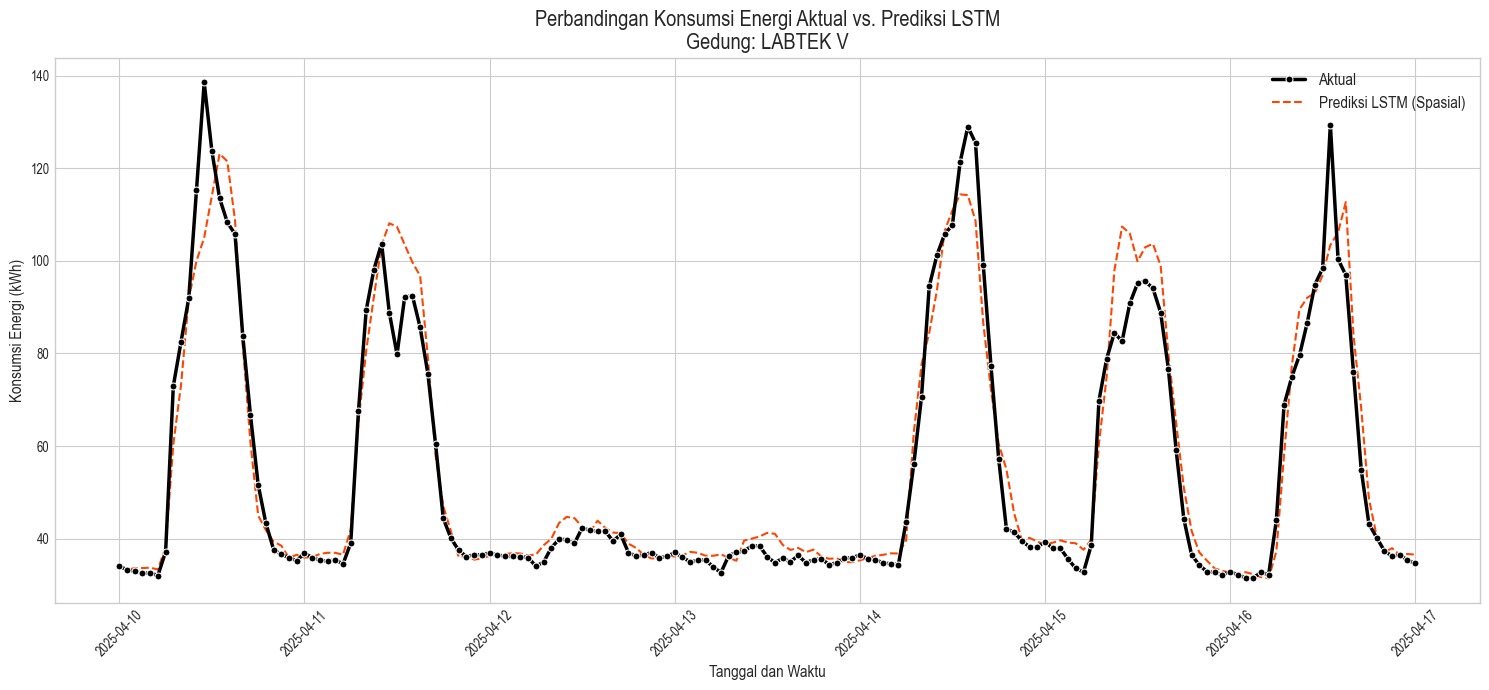

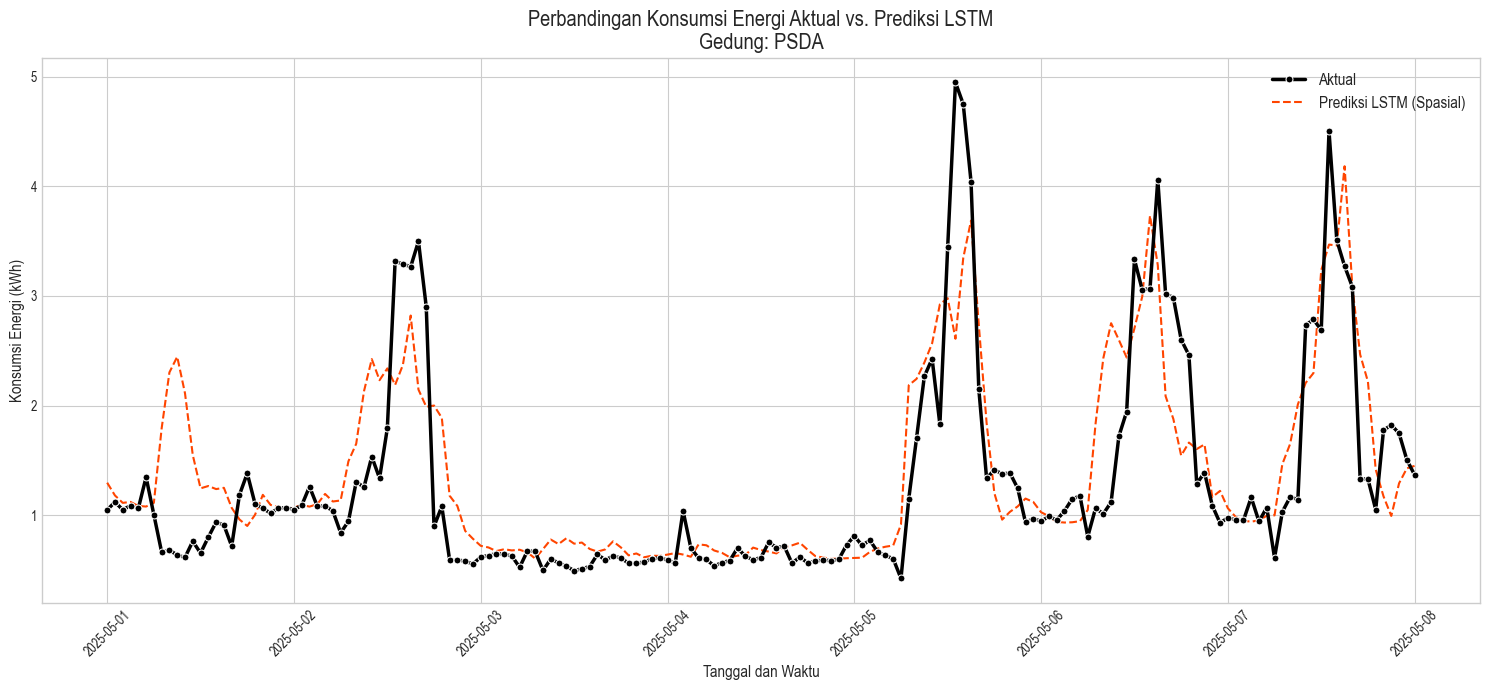

In [23]:
# --- PERUBAHAN ---
# Tahap 5: Visualisasi Hasil
# ==========================================

def plot_lstm_results(df, meter_id='all', start_date='all', end_date='all'):
    """
    Membuat plot perbandingan antara nilai aktual dan prediksi LSTM.

    Args:
        df (pd.DataFrame): DataFrame yang berisi kolom 'timestamp', 'meter_id', 
                           'target_aktual', dan 'prediksi_lstm'.
        meter_id (str, optional): ID gedung yang ingin divisualisasikan. 
                                  Default ke 'all'.
        start_date (str, optional): Tanggal mulai (YYYY-MM-DD). 
                                     Default ke 'all'.
        end_date (str, optional): Tanggal selesai (YYYY-MM-DD). 
                                   Default ke 'all'.
    """
    
    # Membuat salinan untuk menghindari SettingWithCopyWarning
    plot_data = df.copy()

    # Filter berdasarkan meter_id
    if meter_id != 'all':
        plot_data = plot_data[plot_data['meter_id'] == meter_id]
        title_meter = f"Gedung: {meter_id}"
    else:
        # Jika 'all', lebih baik tidak diplot karena akan tumpang tindih dan tidak terbaca.
        # Kita sarankan untuk memilih gedung spesifik.
        print("Untuk visualisasi yang jelas, mohon pilih 'meter_id' yang spesifik.")
        return

    # Filter berdasarkan rentang tanggal
    if start_date != 'all':
        plot_data = plot_data[plot_data['timestamp'] >= pd.to_datetime(start_date)]
    if end_date != 'all':
        plot_data = plot_data[plot_data['timestamp'] <= pd.to_datetime(end_date)]
    
    # Cek apakah data ada setelah filter
    if plot_data.empty:
        print(f"Peringatan: Tidak ada data untuk kriteria yang dipilih (Gedung: {meter_id}, Rentang: {start_date} s/d {end_date}).")
        return
        
    # Membuat plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    
    sns.lineplot(data=plot_data, x='timestamp', y='target_aktual', label='Aktual', color='black', linewidth=2.5, marker='o', markersize=5, zorder=3)
    sns.lineplot(data=plot_data, x='timestamp', y='prediksi_lstm', label='Prediksi LSTM (Spasial)', color='orangered', linestyle='--', zorder=2)
    
    plt.title(f'Perbandingan Konsumsi Energi Aktual vs. Prediksi LSTM\n{title_meter}', fontsize=16)
    plt.xlabel('Tanggal dan Waktu', fontsize=12)
    plt.ylabel('Konsumsi Energi (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Contoh Penggunaan Fungsi Visualisasi ---
print("\n--- Menampilkan Contoh Visualisasi Hasil ---")

# 1. Visualisasi untuk gedung 'LABTEK V' selama satu minggu
plot_lstm_results(
    df=df_hasil, 
    meter_id='LABTEK V', 
    start_date='2025-04-10', 
    end_date='2025-04-17'
)

# 2. Visualisasi untuk gedung lain, misalnya 'GKU BARAT'
plot_lstm_results(
    df=df_hasil, 
    meter_id='PSDA', 
    start_date='2025-05-01', 
    end_date='2025-05-08'
)

# 3. Contoh jika tidak memilih rentang tanggal (menampilkan semua data uji untuk gedung tsb)
# plot_lstm_results(df=df_hasil, meter_id='PAU')
